# GRASS GIS 101: A Script for Computing NDVI

In this final part, we will:
1. Enhance the color and display the RGB image
2. Adjust Computational Region
3. Compute NDVI
4. Get NDVI Stats for each land cover class
5. Make a plot comparing NDVI and land cover class
6. Export above process as python file (This is how you start writing your own GRASS functions!)

In [61]:
import subprocess
import sys
from pathlib import Path
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True, shell=False).strip()
)

# Import the GRASS GIS packages we need.
import grass.script as gs
import grass.jupyter as gj

# Start GRASS Session
session = gj.init("./NC_Sentinel/PERMANENT")

## 1. Displaying RGB Imagery

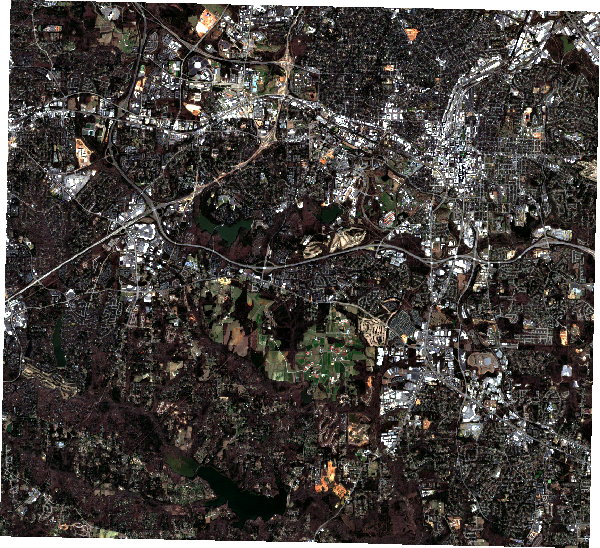

In [9]:
rgb_example = gj.Map()
rgb_example.d_rgb(red="B04_10m", green="B03_10m", blue="B02_10m")
rgb_example.show()

In [10]:
# set color table of bands 4, 3 and 2 to grey
gs.run_command("r.colors", map="B04_10m,B03_10m,B02_10m", color="grey")

# color enhancing for RGB composition
gs.run_command(
    "i.colors.enhance", 
    red="B04_10m",
    green="B03_10m", 
    blue="B02_10m",
    strength=98
)

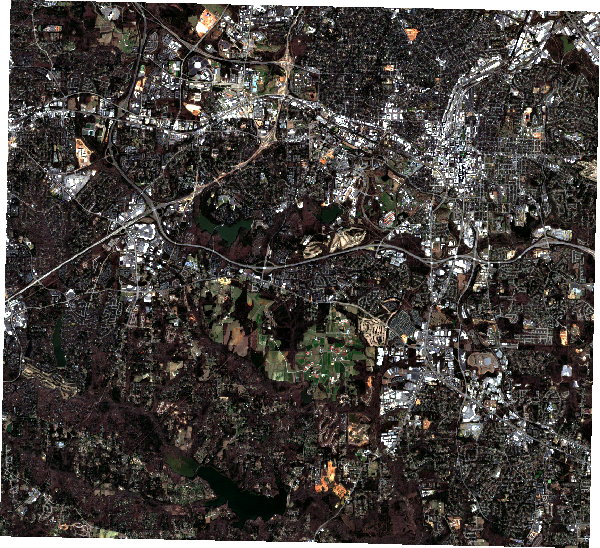

In [11]:
rgb_example = gj.Map()
rgb_example.d_rgb(red="B04_10m", green="B03_10m", blue="B02_10m")
rgb_example.show()

In [15]:
!r.composite red=B04_10m green=B03_10m blue=B02_10m output=rgb_composite

Creating color table for output raster map...
   0   6  12  18  25  31  37  43  50  56  62  68  75  81  87  93 100
Writing raster map <rgb_composite>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
r.composite complete. Raster map <rgb_composite> created.


In [ ]:
composite = gj.Map()
composite.d_rast(map="rgb_composite")
composite.show()

In [ ]:
composite.d_barscale()
composite.show()

## 2. Adjust Computational Region

In [18]:
!g.region -p

projection: 99 (NAD83(HARN) / North Carolina)
zone:       0
datum:      nad83harn
ellipsoid:  grs80
north:      229647.47515809
south:      214184.05225511
west:       629163.71266196
east:       646095.84456931
nsres:      9.79317473
ewres:      9.79302019
rows:       1579
cols:       1729
cells:      2730091


In [21]:
!g.region n=n-400 s=s+400 e=e-400 w=w+400 -p

projection: 99 (NAD83(HARN) / North Carolina)
zone:       0
datum:      nad83harn
ellipsoid:  grs80
north:      229247.47515809
south:      214584.05225511
west:       629563.71266196
east:       645695.84456931
nsres:      9.79520568
ewres:      9.79485847
rows:       1497
cols:       1647
cells:      2465559


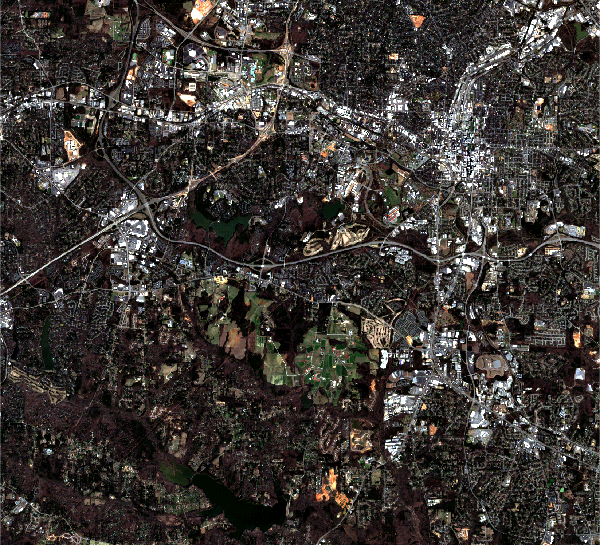

In [22]:
composite = gj.Map(use_region=True)
composite.d_rast(map="rgb_composite")
composite.show()

## 3. Compute NDVI

In [23]:
!r.mapcalc "ndvi = float(B08_10m - B04_10m) / (B08_10m - B04_10m)"

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


In [26]:
!i.vi red=B04_10m nir=B08_10m viname=ndvi output=ndvi

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


GRASS has built-in color tables for NDVI in [r.colors](https://grass.osgeo.org/grass83/manuals/r.colors.html) (check out all the options!).

Color table for raster map <ndvi> set to 'ndvi'


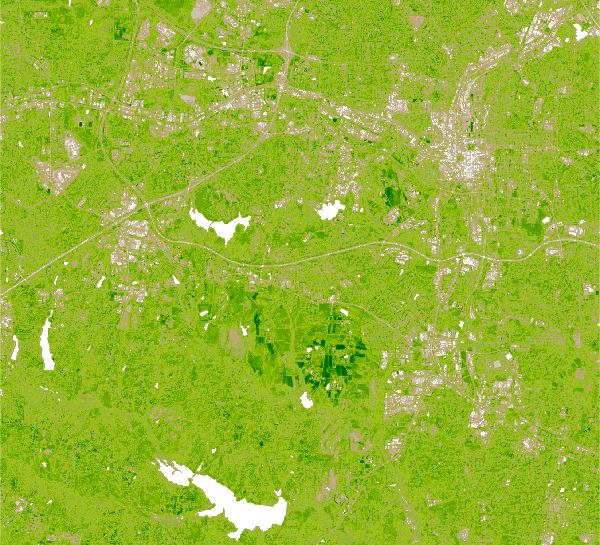

In [27]:
!r.colors map=ndvi color=ndvi

ndvi = gj.Map()
ndvi.d_rast(map="ndvi")
ndvi.show()

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Color table for raster map <ndwi> set to 'byg'


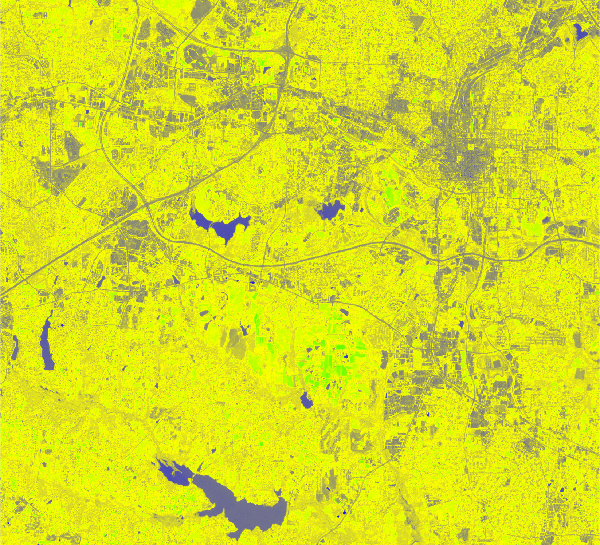

In [28]:
!i.vi green=B04_10m nir=B08_10m viname=ndwi output=ndwi
!r.colors ndwi color=byg -n

ndwi = gj.Map()
ndwi.d_rast(map="ndwi")
ndwi.show()

## 4. Get NDVI by Land Cover Class

In [42]:
!r.import input=./landcover/NLCD_2021.tiff extent=region output=landcover

Building topology for vector map
<tmp_r_import_region_gis_lab_50_cnr_ncsu_edu_62370@PERMANENT>...
Registering primitives...
Building areas...
   0 100
Attaching islands...
   0 100
Attaching centroids...
   0 100
Found 3 possible transformations
hgridshift: could not find required grid(s).
pipeline: Pipeline: Bad step definition: inv (File not found or invalid)
hgridshift: could not find required grid(s).
pipeline: Pipeline: Bad step definition: inv (File not found or invalid)
************************
Operation 1:
Description: Inverse of SPCS83 North Carolina zone (meters) + Inverse of
NAD83 to NAD83(HARN) (44) + Albers Equal Area

Area of use: United States (USA) - North Carolina - counties of Alamance;
Alexander; Alleghany; Anson; Ashe; Avery; Beaufort; Bertie; Bladen;
Brunswick; Buncombe; Burke; Cabarrus; Caldwell; Camden; Carteret; Caswell;
Catawba; Chatham; Cherokee; Chowan; Clay; Cleveland; Columbus; Craven;
Cumberland; Currituck; Dare; Davidson; Davie; Duplin; Durham; Edgecombe;

In [43]:
!r.colors map=landcover rules=./landcover/nlcd_colors.txt
!r.category map=landcover separator=pipe rules=./landcover/nlcd_categories.txt

Color table for raster map <landcover> set to './landcover/nlcd_colors.txt'


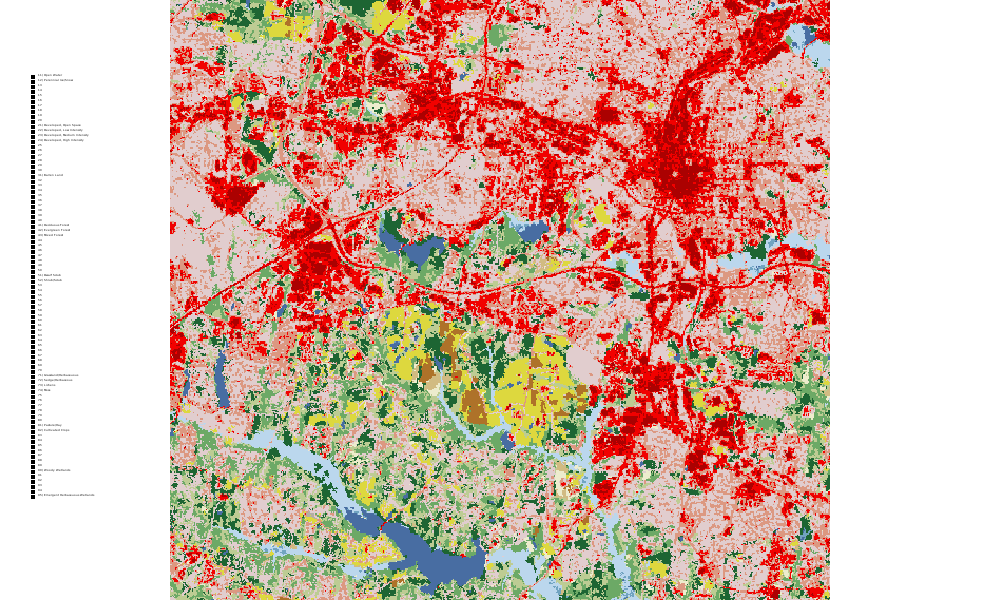

In [52]:
landcover = gj.Map(use_region=True, width=1000, height=600)
landcover.d_rast(map="landcover")
landcover.d_legend(raster="landcover")
landcover.show()

In [102]:
stats = gs.read_command("r.univar", flags="t", map="ndvi", zones="landcover", separator="pipe").strip()
df = pd.read_csv(StringIO(stats), sep="|")

df

zone                          label  non_null_cells  null_cells       min  \
0     11                     Open Water           45450           0 -0.281325   
1     21          Developed, Open Space          718569           0 -0.212317   
2     22       Developed, Low Intensity          504052           0 -0.255692   
3     23    Developed, Medium Intensity          367209           0 -0.252019   
4     24      Developed, High Intensity          122298           0 -0.215162   
5     31                    Barren Land            3367           0 -0.216425   
6     41               Deciduous Forest          161049           0 -0.146795   
7     42               Evergreen Forest          152032           0 -0.222877   
8     43                   Mixed Forest          178555           0 -0.242656   
9     52                    Shrub/Scrub           10880           0 -0.109819   
10    71          Grassland/Herbaceuous           19701           0 -0.306332   
11    81                    Pasture/Hay           96341           0 -0.168004   
12    82               Cultivated Crops           15513           0  0.020095   
13    90                 Woody Wetlands           66434           0 -0.121803   
14    95  Emergent Herbaceuous Wetlands            4109           0 -0.118555   

         max     range      mean  mean_of_abs    stddev  variance   coeff_var  \
0   0.492695  0.774020 -0.020988     0.083694  0.104179  0.010853 -496.371331   
1   0.663183  0.875500  0.262942     0.263076  0.079883  0.006381   30.380670   
2   0.657834  0.913526  0.219081     0.219200  0.087419  0.007642   39.902508   
3   0.639242  0.891261  0.144337     0.144751  0.088783  0.007882   61.511082   
4   0.588829  0.803992  0.071055     0.073184  0.069015  0.004763   97.128388   
5   0.505906  0.722331  0.167301     0.167984  0.099213  0.009843   59.302222   
6   0.629787  0.776582  0.225888     0.226009  0.050571  0.002557   22.387546   
7   0.878390  1.101267  0.315322     0.315459  0.073331  0.005377   23.255983   
8   0.625424  0.868080  0.269535     0.269606  0.063793  0.004070   23.667651   
9   0.585866  0.695685  0.229526     0.229693  0.080694  0.006511   35.156702   
10  0.554772  0.861104  0.186760     0.188257  0.099979  0.009996   53.533753   
11  0.680752  0.848757  0.306713     0.306796  0.110004  0.012101   35.865607   
12  0.655333  0.635238  0.317472     0.317472  0.122161  0.014923   38.479399   
13  0.527877  0.649681  0.221073     0.221522  0.063957  0.004091   28.930412   
14  0.464359  0.582914  0.156724     0.166395  0.101938  0.010391   65.043253   

              sum        sum_abs  
0     -953.909039    3803.896628  
1   188941.786789  189037.982295  
2   110428.141126  110487.982282  
3    53001.761658   53154.028311  
4     8689.875656    8950.222006  
5      563.302343     565.601751  
6    36379.002770   36398.518418  
7    47938.968533   47959.836022  
8    48126.881363   48139.465593  
9     2497.241658    2499.063711  
10    3679.352020    3708.852559  
11   29548.992349   29557.001236  
12    4924.941007    4924.941007  
13   14686.770647   14716.619368  
14     643.979058     683.715504

## 5. Plot Comparing NDVI and Land Cover Type

In [94]:
# Read colors from the text file
file_path = './landcover/nlcd_colors.txt'
with open(file_path, 'r') as file:
    next(file)
    next(file)
    colors_str = file.read()

# Split the string into lines
lines = colors_str.split('\n')

# Extract RGB values and convert to RGB triplets
custom_colors = []
for line in lines:
    if line.strip():  # Check if line is not empty
        parts = line.split()  # Split line into parts
        color_code = int(parts[0])  # Extract color code
        rgb_values = [int(val) / 255.0 for val in parts[1].split(':')]  # Convert RGB values to 0-1 range
        rgb_triplet = tuple(rgb_values)  # Create RGB triplet
        custom_colors.append(rgb_triplet)  # Add RGB triplet to list

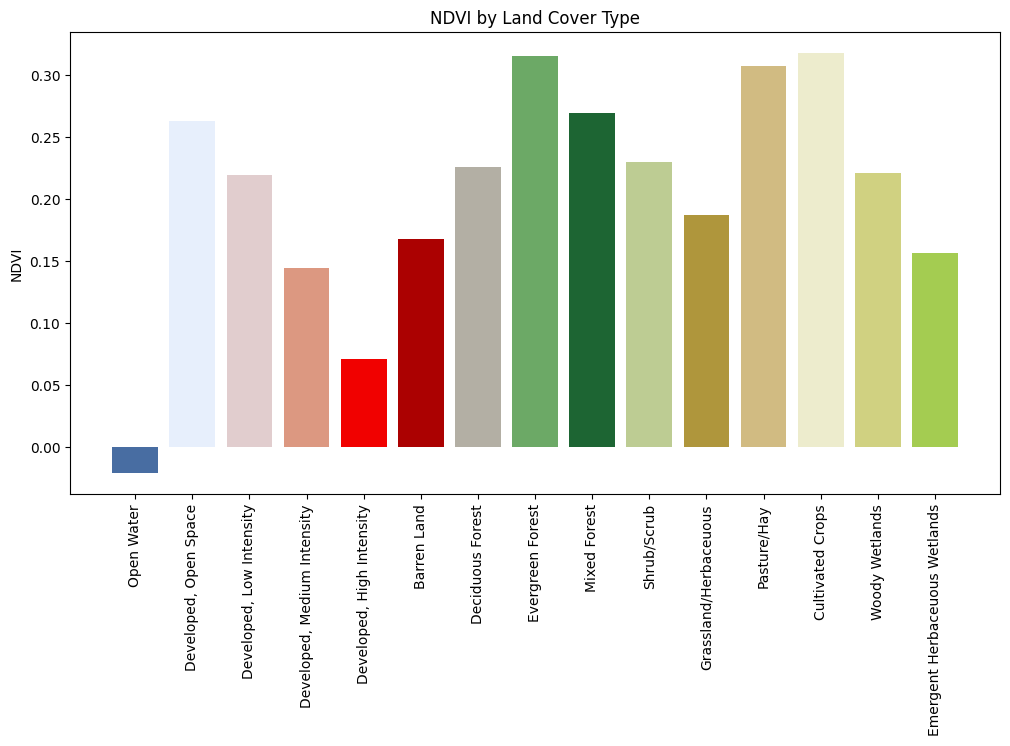

In [104]:
# Plotting the bar chart
plt.figure(figsize=(12, 6))
plt.bar(df['label'], df['mean'], color=custom_colors)  # Create the bar plot

# Adding labels and title
plt.ylabel('NDVI')
plt.title('NDVI by Land Cover Type')

# Displaying the plot
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

## 6. Convert to a Script!

In [ ]:
%%file NDVI_LandCover.py
#!/usr/bin/env python3

from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt
import grass.script as gs


def ndvi_landcover(red_raster, NIR_raster, nlcd, out_filename):
    # Compute NDVI
    gs.run_command("i.vi", red=red, nir=nir, viname="ndvi", output="ndvi")
    
    stats = gs.read_command("r.univar", flags="t", map="ndvi", zones="landcover", separator="pipe").strip()
    df = pd.read_csv(StringIO(stats), sep="|")
    
    # Read colors from the text file
    file_path = './landcover/nlcd_colors.txt'
    with open(file_path, 'r') as file:
        next(file)
        next(file)
        colors_str = file.read()

    # Split the string into lines
    lines = colors_str.split('\n')

    # Extract RGB values and convert to RGB triplets
    custom_colors = []
    for line in lines:
        if line.strip():  # Check if line is not empty
            parts = line.split()  # Split line into parts
            color_code = int(parts[0])  # Extract color code
            rgb_values = [int(val) / 255.0 for val in parts[1].split(':')]  # Convert RGB values to 0-1 range
            rgb_triplet = tuple(rgb_values)  # Create RGB triplet
            custom_colors.append(rgb_triplet)  # Add RGB triplet to list
            
    # Plotting the bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(df['label'], df['mean'], color=custom_colors)  # Create the bar plot

    # Adding labels and title
    plt.ylabel('NDVI')
    plt.title('NDVI by Land Cover Type')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    
    # Save the plot as a PNG file
    plt.savefig(out_filename)

if __name__ == "__main__":
    ndvi_landcover("B04_10m", "B08_10m", "landcover", "plot.png")